In [2]:
import numpy as np
import torch as t # Keep import as torch is also needed
import matplotlib.pyplot as plt

from pa_generator.data_augmentation import DataLoaderAug, ANOMALY_TYPE_DEFAULTS, COMMON_ANOMALY_PARAMS
from pa_generator.data_augmentation import AnomalyInjector # Needed for generate_anomaly_types_from_one_hot

# --- Create Dummy Data ---
# Random time series data with 2 features and 1000 time steps
dataset = np.random.randn(2, 1000)

print("Loading augmentation modules...")

# --- Instantiate DataLoaderAug and Generate Data ---
# Generate spike, noise, normal data, and random anomalies
# Modify spike scale and noise scale with custom parameters
loader = DataLoaderAug(
    dataset=dataset,
    anomaly_types=['normal', 'spike', 'noise', 'random'], # Specifying 'random' selects a random anomaly
    params={
        'spike': {'scale': 1, 'min_features': 2, 'max_features': 2},
        'noise': {'scale': 1.5},
        'average': {'ma_window': 10}, # Parameter for testing 'average'
        # If 'random' requires specific parameters, define them here
    },
    window_size=100,
    window_step=50,
    minmax=True,
)

# --- Accessing Generated Data ---
y_anomalous = loader.Y_windows       # Windowed data after anomaly injection
z_normal = loader.Z_windows          # Original windowed data before anomaly injection
anomaly_mask = loader.anomaly_mask   # Mask indicating anomaly locations (0 is anomaly)
labels_one_hot = loader.label        # One-Hot label of anomaly type for each window

print(f"\n--- Generation Summary ---")
print(f"Total number of windows generated: {y_anomalous.shape[0]}")
print(f"Shape of Y_anomalous: {y_anomalous.shape}") # [B, D, W]
print(f"Shape of Z_normal: {z_normal.shape}")       # [B, D, W]
print(f"Shape of anomaly_mask: {anomaly_mask.shape}") # [B, D, W]
print(f"Shape of labels_one_hot: {labels_one_hot.shape}") # [B, N_anomaly_types]

# --- Label Conversion and Display ---
# Convert One-Hot to original anomaly type names using AnomalyInjector's static method
# DataLoaderAug inherits from AnomalyInjector, so the method can be called directly
first_100_labels_str = loader.generate_anomaly_types(labels_one_hot[:100], loader.anomaly_dict)
print(f"First 100 anomaly type labels: {first_100_labels_str}")

print(f"\n--- Sample Count for Each Anomaly Type ---")
# Convert all labels to strings
all_labels_str = loader.generate_anomaly_types(labels_one_hot, loader.anomaly_dict)
from collections import Counter
label_counts = Counter(all_labels_str)
for label, count in label_counts.items():
    print(f"  '{label}': {count} samples")

Loading augmentation modules...

--- Generation Summary ---
Total number of windows generated: 76
Shape of Y_anomalous: torch.Size([76, 2, 100])
Shape of Z_normal: torch.Size([76, 2, 100])
Shape of anomaly_mask: torch.Size([76, 2, 100])
Shape of labels_one_hot: torch.Size([76, 13])
First 100 anomaly type labels: ['normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'spike', 'spike', 'spike', 'spike', 'spike', 'spike', 'spike', 'spike', 'spike', 'spike', 'spike', 'spike', 'spike', 'spike', 'spike', 'spike', 'spike', 'spike', 'spike', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'spike', 'noise', 'flip', 'speedup', 'noise', 'speedup', 'speedup', 'average', 'flip', 'scale', 'noise', 'scale', 'spike', 'noise', 'wander', 'speedup', 


--- Visualization of Anomaly Injection Results ---


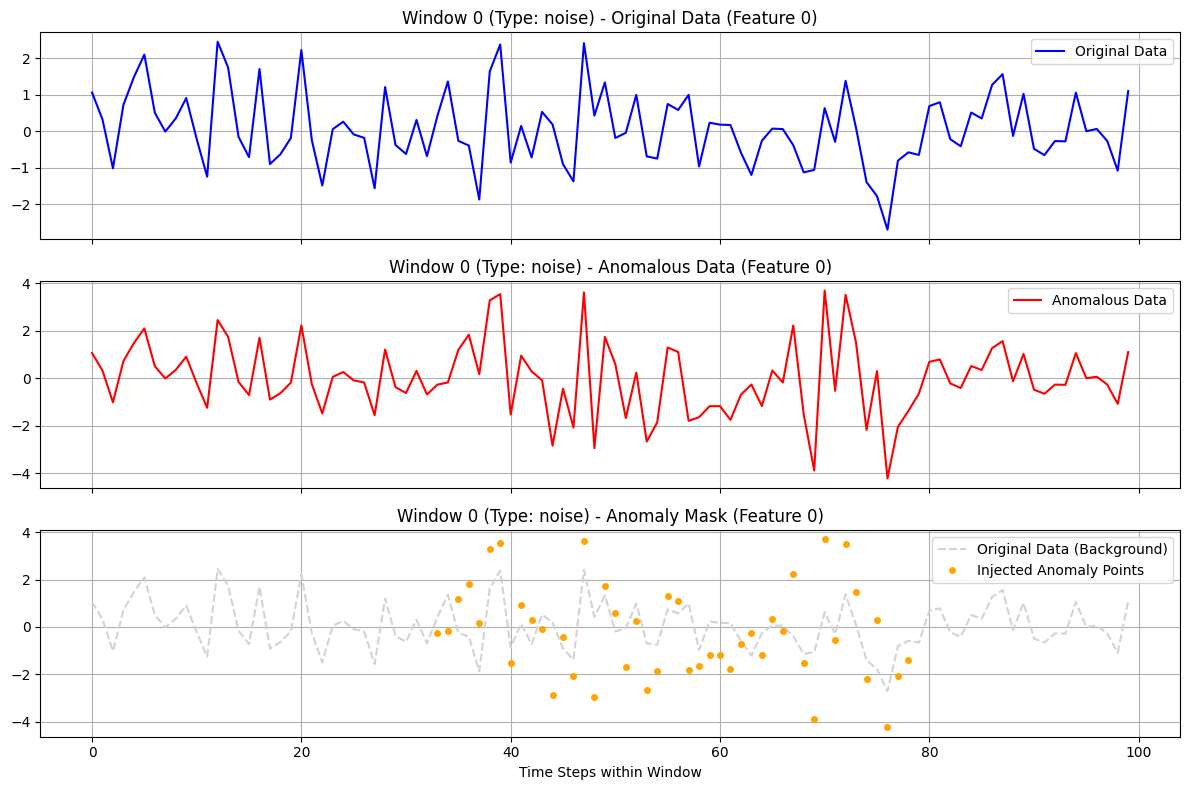

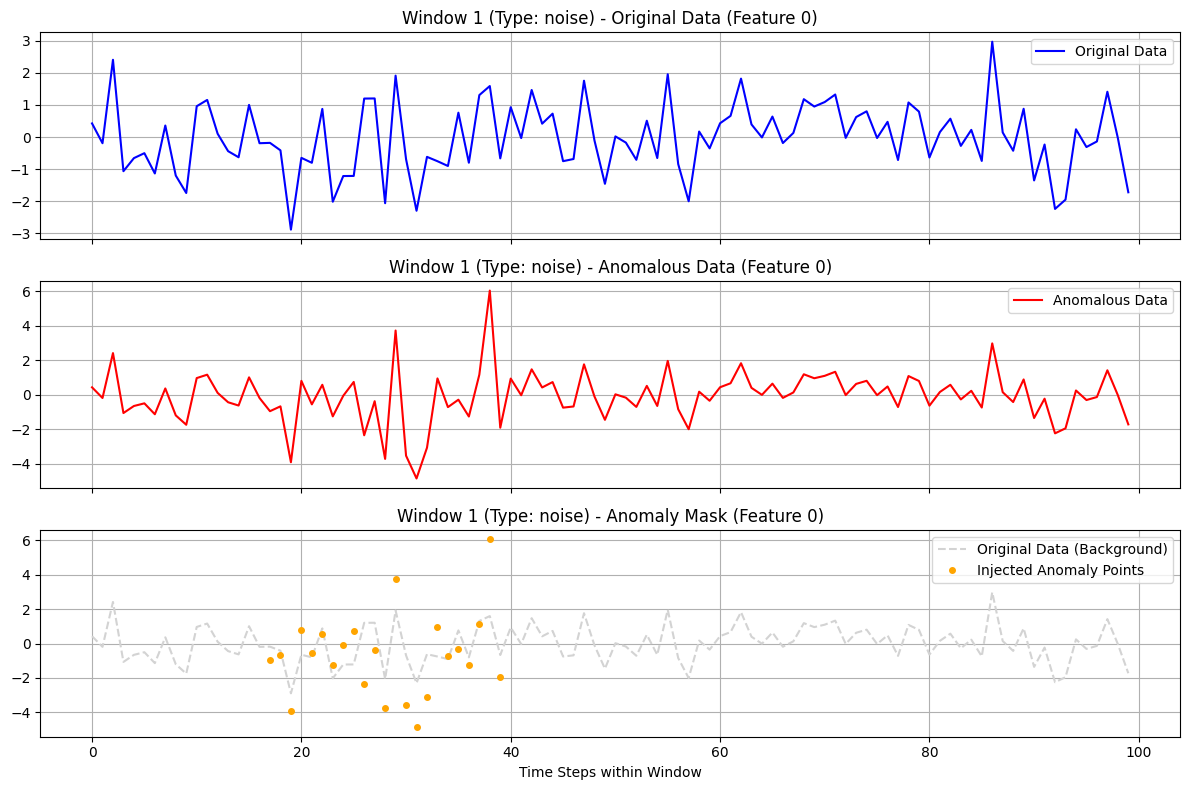

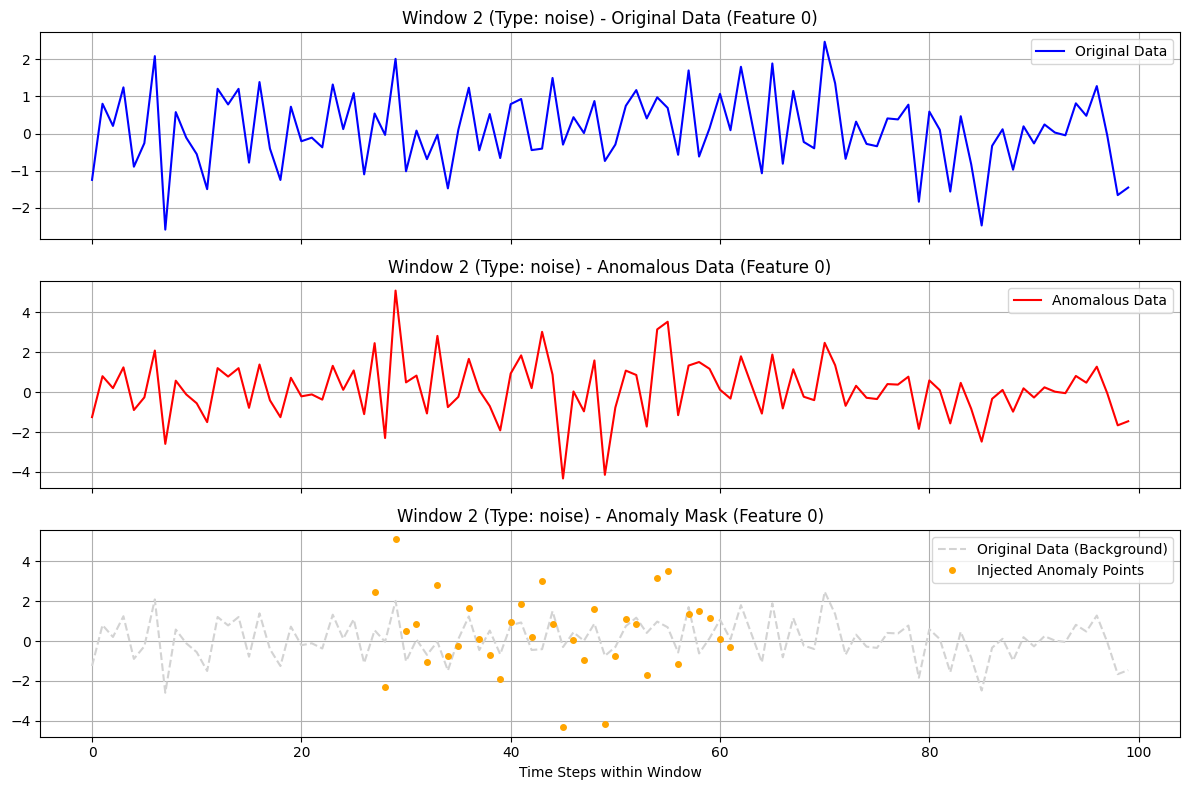

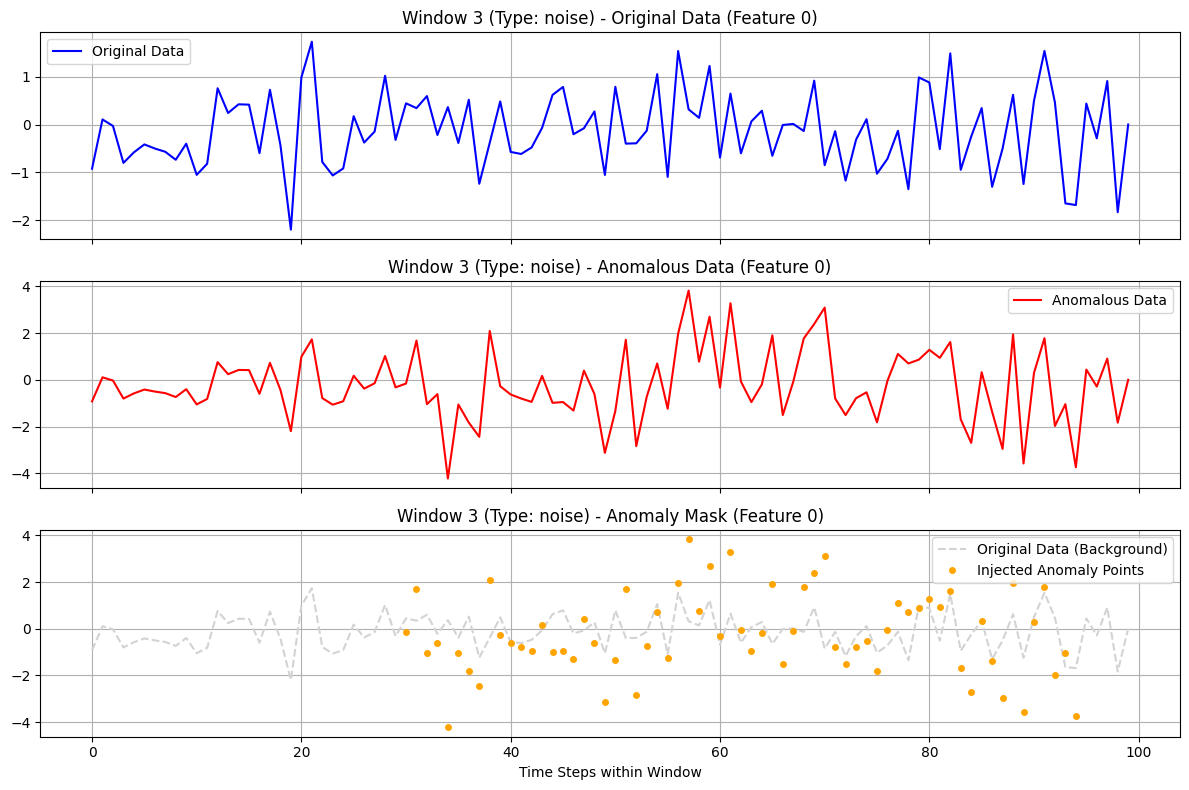

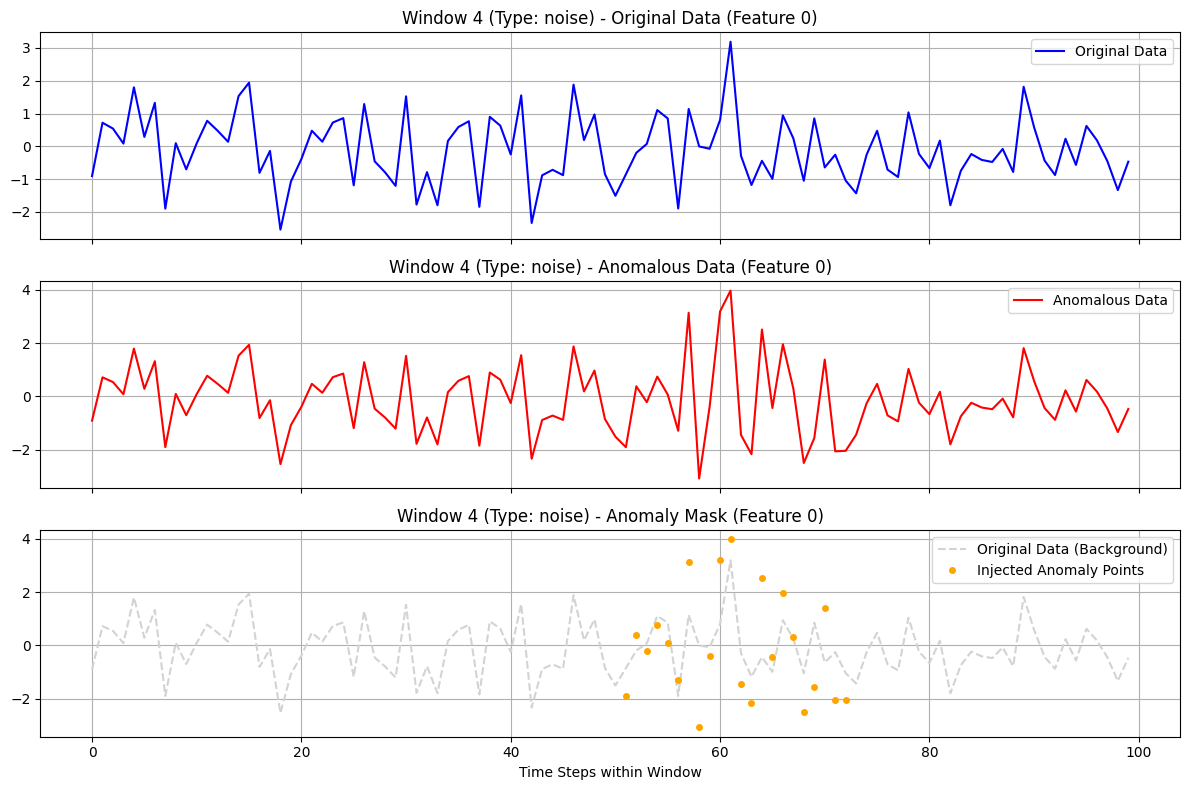

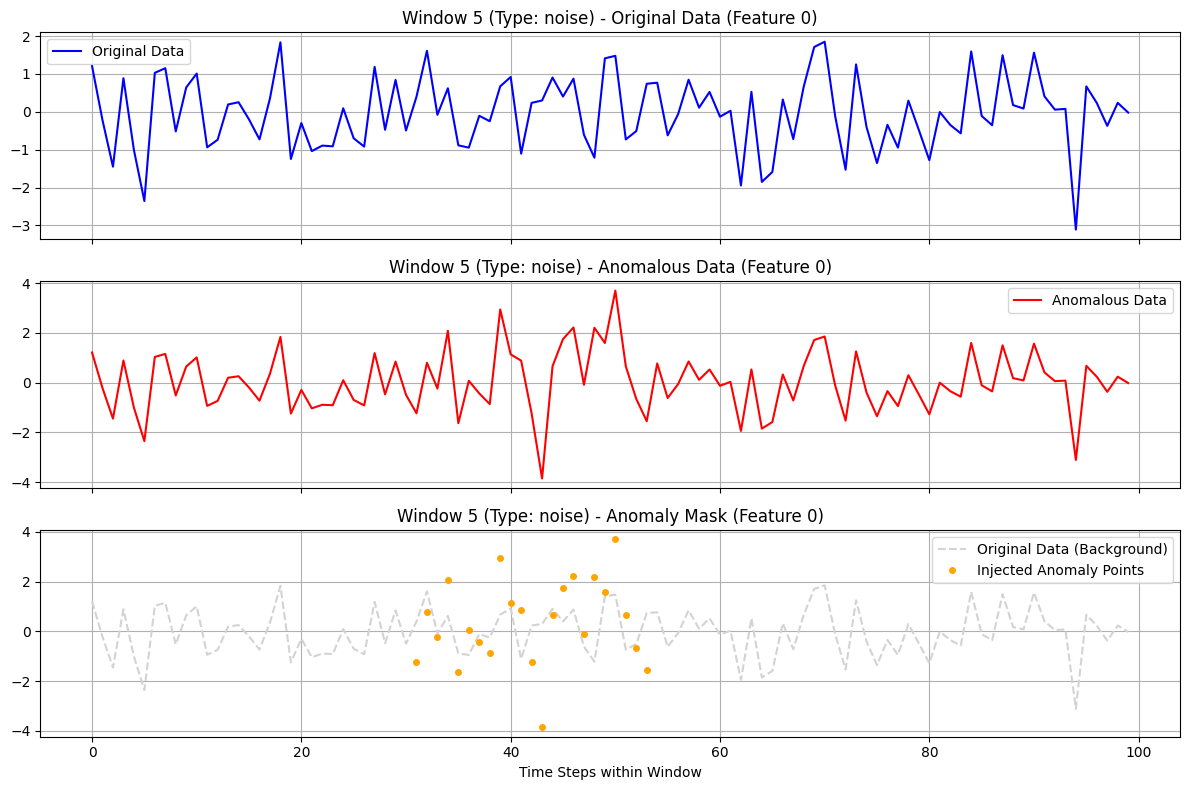

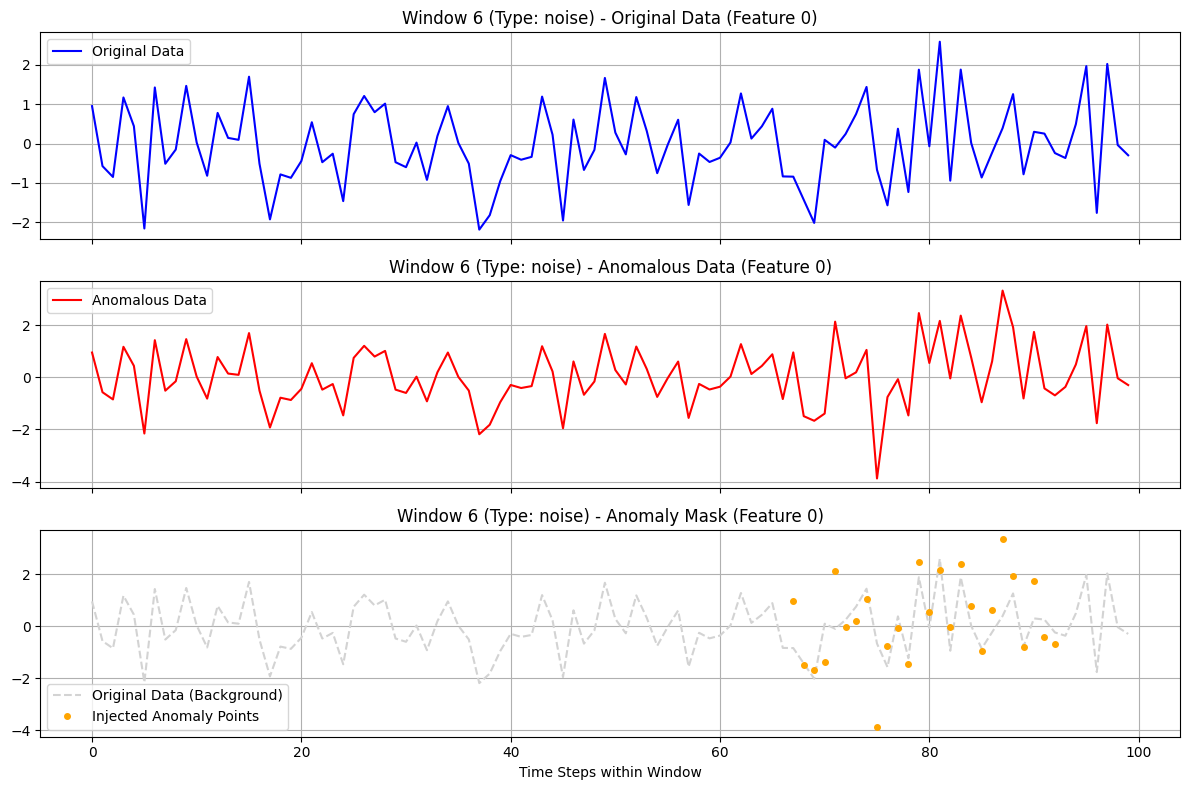

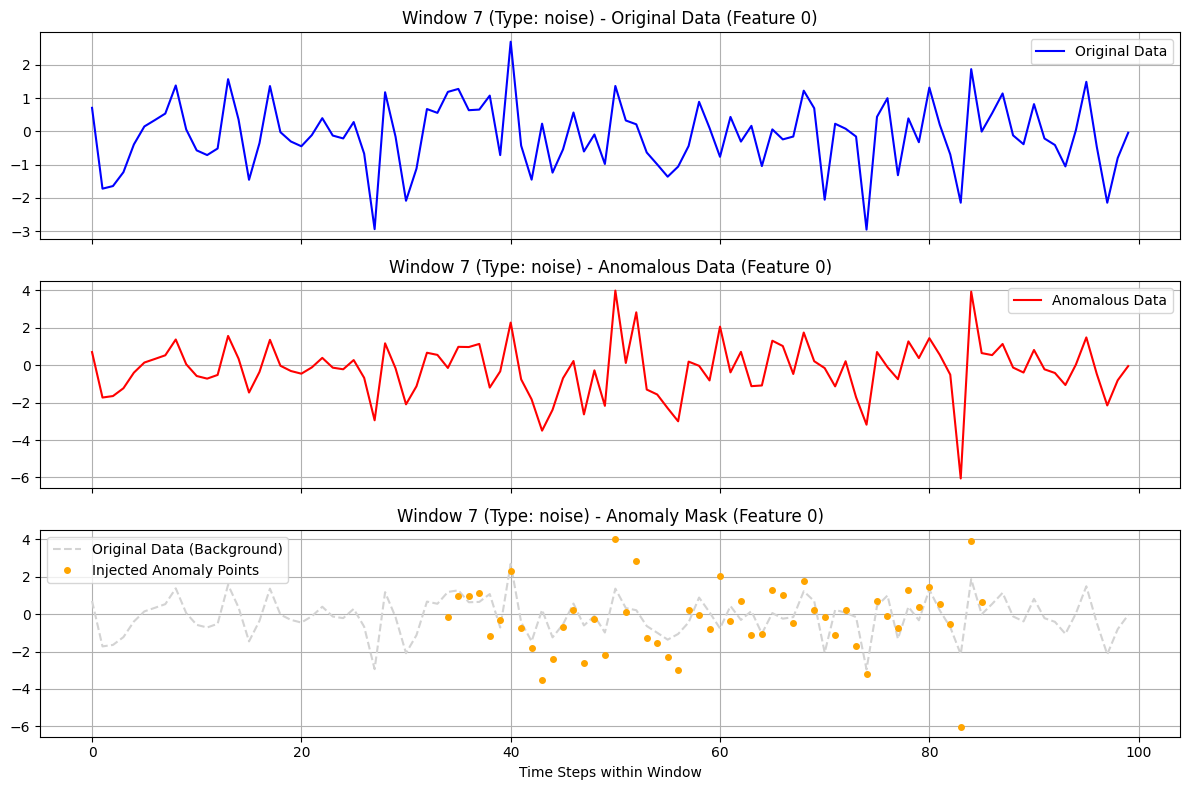

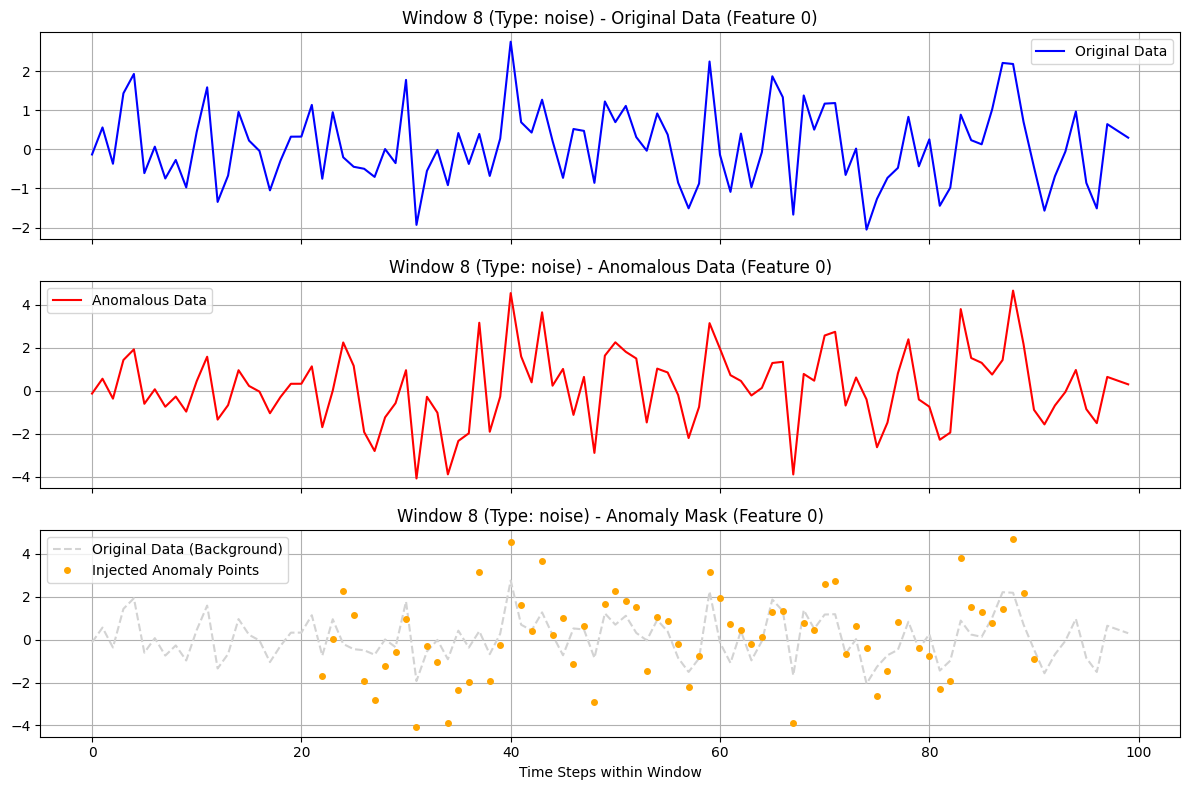

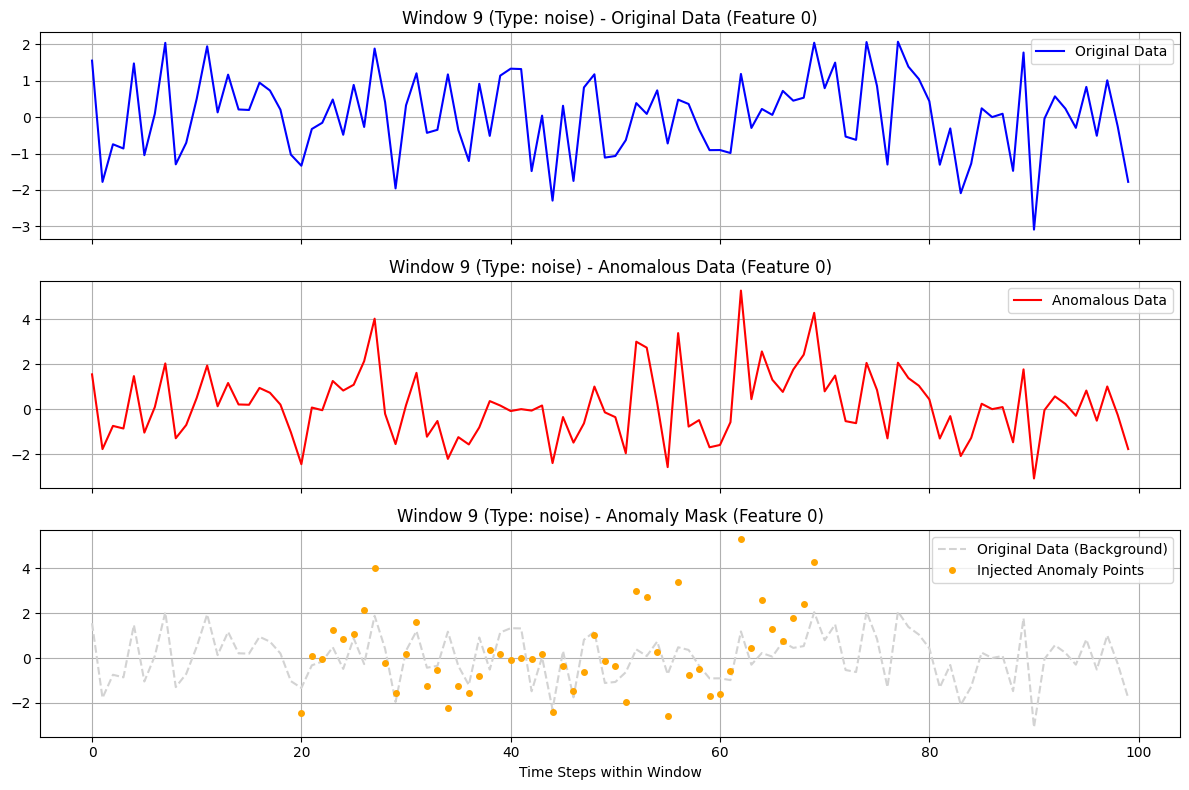

In [5]:
## Visualization

# Next, we'll select a few windows from the generated data and visualize the original data, the data after anomaly injection, and the anomaly mask. This will allow us to visually confirm how anomalies were injected.

# --- Visualization Function ---
def plot_anomaly_injection(
    original_data: t.Tensor,
    anomalous_data: t.Tensor,
    anomaly_mask: t.Tensor,
    anomaly_type: str,
    window_idx: int,
    feature_idx: int = 0
):
    """
    Visualizes data before and after anomaly injection.

    Parameters
    ----------
    original_data : torch.Tensor
        The original window data (Z_windows).
    anomalous_data : torch.Tensor
        The window data after anomaly injection (Y_windows).
    anomaly_mask : torch.Tensor
        The anomaly mask (0 indicates an anomaly).
    anomaly_type : str
        The anomaly type name for this window.
    window_idx : int
        The index of the window to display.
    feature_idx : int, optional
        The index of the feature to display. Defaults to 0.
    """
    fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
    time_points = np.arange(original_data.shape[2]) # Length of the window

    # Original data
    axes[0].plot(time_points, original_data[window_idx, feature_idx].cpu().numpy(), label='Original Data', color='blue')
    axes[0].set_title(f'Window {window_idx} (Type: {anomaly_type}) - Original Data (Feature {feature_idx})')
    axes[0].legend()
    axes[0].grid(True)

    # Data after anomaly injection
    axes[1].plot(time_points, anomalous_data[window_idx, feature_idx].cpu().numpy(), label='Anomalous Data', color='red')
    axes[1].set_title(f'Window {window_idx} (Type: {anomaly_type}) - Anomalous Data (Feature {feature_idx})')
    axes[1].legend()
    axes[1].grid(True)

    # Anomaly mask
    # Since the mask is 0 for anomalies, highlight anomaly locations with 1-mask
    anomaly_locations = (anomaly_mask[window_idx, feature_idx].cpu().numpy() == 0)

    axes[2].plot(time_points, original_data[window_idx, feature_idx].cpu().numpy(), color='lightgray', linestyle='--', label='Original Data (Background)') # Original data in background
    axes[2].plot(time_points[anomaly_locations], anomalous_data[window_idx, feature_idx, anomaly_locations].cpu().numpy(),
                 'o', markersize=4, color='orange', label='Injected Anomaly Points')
    axes[2].set_title(f'Window {window_idx} (Type: {anomaly_type}) - Anomaly Mask (Feature {feature_idx})')
    axes[2].set_xlabel('Time Steps within Window')
    axes[2].legend()
    axes[2].grid(True)

    plt.tight_layout()
    plt.show()

# --- Execute Visualization ---
print(f"\n--- Visualization of Anomaly Injection Results ---")

# Select and visualize a few random windows
num_plots = 10 # Number of windows to visualize
num_total_windows = y_anomalous.shape[0]

# If possible, select and visualize windows with specific anomaly types
# For example, look for 'spike' or 'noise' samples
sample_indices_to_plot = []
plotted_types = set()

# Try 'normal', 'spike', 'noise', 'flip', 'speedup', 'average', 'scale', 'wander', 'contextual', 'upsidedown', 'mixture' in order
desired_plot_types = ['normal', 'spike', 'noise', 'flip', 'speedup', 'average', 'scale', 'wander', 'contextual', 'upsidedown', 'mixture']
type_idx = 0

for i in range(num_total_windows):
    current_type = loader.generate_anomaly_types(labels_one_hot[i:i+1], loader.anomaly_dict)[0]

    if current_type == desired_plot_types[type_idx] and current_type not in plotted_types:
        sample_indices_to_plot.append(i)
        plotted_types.add(current_type)
        type_idx += 1
        if type_idx >= len(desired_plot_types) or len(sample_indices_to_plot) >= num_plots:
            break

# If specific types are not found, simply display the first few
if len(sample_indices_to_plot) < num_plots:
    remaining_plots = num_plots - len(sample_indices_to_plot)
    for i in range(num_total_windows):
        if i not in sample_indices_to_plot and remaining_plots > 0:
            sample_indices_to_plot.append(i)
            remaining_plots -= 1
        if remaining_plots == 0:
            break

for idx in sample_indices_to_plot:
    current_anomaly_type = loader.generate_anomaly_types(labels_one_hot[idx:idx+1], loader.anomaly_dict)[0]
    # If there are multiple features, you can choose to randomly select a feature or visualize all features
    # For convenience, feature 0 is visualized here
    plot_anomaly_injection(z_normal, y_anomalous, anomaly_mask, current_anomaly_type, idx, feature_idx=0)

In [1]:
import numpy as np
import torch as t # Keep import as torch is also needed
import matplotlib.pyplot as plt

from pa_generator.data_augmentation import DataLoaderAugBatch, ANOMALY_TYPE_DEFAULTS, COMMON_ANOMALY_PARAMS
from pa_generator.data_augmentation import AnomalyInjector # Needed for generate_anomaly_types_from_one_hot

# --- Create Dummy Data ---
# Random time series data with 2 features and 1000 time steps
dataset = np.random.randn(16, 2, 100)

print("Loading augmentation modules...")

# --- Instantiate DataLoaderAug and Generate Data ---
# Generate spike, noise, normal data, and random anomalies
# Modify spike scale and noise scale with custom parameters
loader = DataLoaderAugBatch(
    dataset=dataset,
    anomaly_types=['normal', 'spike', 'noise', 'random'], # Specifying 'random' selects a random anomaly
    params={
        'spike': {'scale': 1, 'min_features': 2, 'max_features': 2},
        'noise': {'scale': 1.5, 'min_features': 2, 'max_features': 2},
        'average': {'ma_window': 10}, # Parameter for testing 'average'
        # If 'random' requires specific parameters, define them here
    },
    minmax=True,
)

# --- Accessing Generated Data ---
y_anomalous = loader.Y_batches       # Windowed data after anomaly injection
z_normal = loader.Z_batches          # Original windowed data before anomaly injection
anomaly_mask = loader.anomaly_mask_batches   # Mask indicating anomaly locations (0 is anomaly)
labels_one_hot = loader.label_batches        # One-Hot label of anomaly type for each window

print(f"\n--- Generation Summary ---")
print(f"Total number of windows generated: {y_anomalous.shape[0]}")
print(f"Shape of Y_anomalous: {y_anomalous.shape}") # [B, D, W]
print(f"Shape of Z_normal: {z_normal.shape}")       # [B, D, W]
print(f"Shape of anomaly_mask: {anomaly_mask.shape}") # [B, D, W]
print(f"Shape of labels_one_hot: {labels_one_hot.shape}") # [B, N_anomaly_types]

# --- Label Conversion and Display ---
# Convert One-Hot to original anomaly type names using AnomalyInjector's static method
# DataLoaderAug inherits from AnomalyInjector, so the method can be called directly
first_100_labels_str = loader.generate_anomaly_types(labels_one_hot[:100], loader.anomaly_dict)
print(f"First 100 anomaly type labels: {first_100_labels_str}")

print(f"\n--- Sample Count for Each Anomaly Type ---")
# Convert all labels to strings
all_labels_str = loader.generate_anomaly_types(labels_one_hot, loader.anomaly_dict)
from collections import Counter
label_counts = Counter(all_labels_str)
for label, count in label_counts.items():
    print(f"  '{label}': {count} samples")

Loading augmentation modules...

--- Generation Summary ---
Total number of windows generated: 64
Shape of Y_anomalous: torch.Size([64, 2, 100])
Shape of Z_normal: torch.Size([64, 2, 100])
Shape of anomaly_mask: torch.Size([64, 2, 100])
Shape of labels_one_hot: torch.Size([64, 10])
First 100 anomaly type labels: ['normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'spike', 'spike', 'spike', 'spike', 'spike', 'spike', 'spike', 'spike', 'spike', 'spike', 'spike', 'spike', 'spike', 'spike', 'spike', 'spike', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'wander', 'wander', 'speedup', 'spike', 'scale', 'wander', 'cutoff', 'mixture', 'spike', 'contextual', 'noise', 'scale', 'speedup', 'speedup', 'average', 'cutoff']

--- Sample Count for Each Anomaly Type ---
  'normal': 16 samples
  'spi